# Direct Forecasting with skforecast

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook, we carry out **direct forecasting** to predict multiple steps into the future by using a Lasso regression.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from skforecast.direct import ForecasterDirect

# Load data

We will use the electricity demand dataset found [here](https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec/VIC2015).

**Citation:**

Godahewa, Rakshitha, Bergmeir, Christoph, Webb, Geoff, Hyndman, Rob, & Montero-Manso, Pablo. (2021). Australian Electricity Demand Dataset (Version 1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4659727

**Description of data:**

A description of the data can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). The data contains electricity demand in Victoria, Australia, at 30 minute intervals over a period of 12 years, from 2002 to early 2015. There is also the temperature in Melbourne at 30 minute intervals and public holiday dates.

In [21]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("h")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [3]:
df.tail()

,demand
date_time,
2015-02-28 19:00:00,9596.777060
2015-02-28 20:00:00,8883.230296
2015-02-28 21:00:00,8320.260550
2015-02-28 22:00:00,8110.055916
2015-02-28 23:00:00,8519.368752


In [4]:
# Split into train and test

# We leave 2015 in the test set

end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

## Plot time series

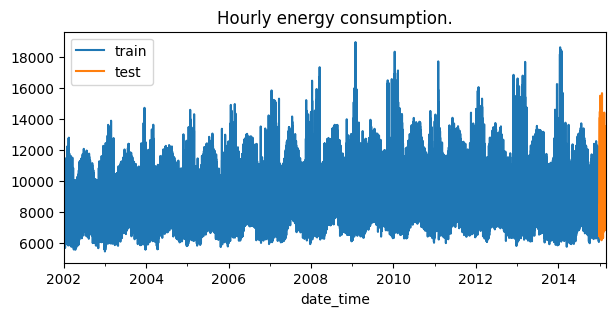

In [5]:
# plot the time series

fig, ax=plt.subplots(figsize=(7, 3))
X_train.plot(ax=ax, label='train')
X_test.plot(ax=ax, label='test')
ax.set_title('Hourly energy consumption.')
ax.legend(["train", "test"])
plt.show()

Too many time points, we don't see much.

Let's plot less time points.

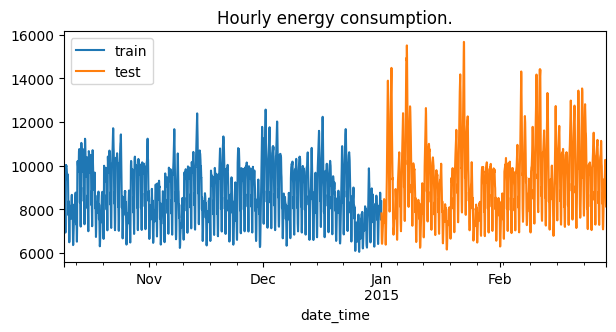

In [6]:
# Let's zoom in to see a bit more detail:

fig, ax = plt.subplots(figsize=(7, 3))
X_train.tail(2000).plot(ax=ax)
X_test.plot(ax=ax)
ax.set_title('Hourly energy consumption.')
ax.legend(["train", "test"])
plt.show()

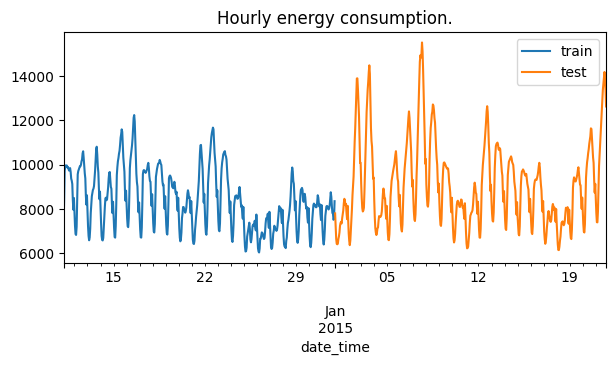

In [7]:
# And zooming in a bit more:

fig, ax = plt.subplots(figsize=(7, 3))
X_train.tail(500).plot(ax=ax)
X_test.head(500).plot(ax=ax)
ax.set_title('Hourly energy consumption.')
ax.legend(["train", "test"])
plt.show()

## Create and train forecaster

In [8]:
# Lasso regression model

lasso = Lasso(random_state=9, max_iter=1000)

In [9]:
forecaster = ForecasterDirect(
    regressor=lasso,            # the machine learning model
    lags=24,                    # the lag features to create
    steps=24,                   # the horizon
    forecaster_id="direct"
)

# fit the forecaster
forecaster.fit(y=X_train["demand"])

# print
forecaster

c:\Users\nuosv\Documents\PYTHON-PROJECTS\TRAINING_DATA_COURSES\forecasting-with-machine-learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e+09, tolerance: 3.156e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\nuosv\Documents\PYTHON-PROJECTS\TRAINING_DATA_COURSES\forecasting-with-machine-learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.398e+09, tolerance: 3.156e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\nuosv\Documents\PYTHON-PROJECTS\TRAINING_DATA_COURSES\forecasting-with-machine-learning\.venv\Lib\site-packages\sklearn\linear_mode

================ 
ForecasterDirect 
================ 
Regressor: Lasso 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: None 
Window size: 24 
Maximum steps to predict: 24 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000,
    'positive': False, 'precompute': False, 'random_state': 9, 'selection':
    'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-02-05 04:45:08 
Last fit date: 2025-02-05 04:47:54 
Skforecast version: 0.14.0 
Python version: 3.12.6 
Forecaster id: direct

The forecaster stores a lot of important information. For example:
    
- `window size` tells us the amount of datapoints in the past that we need to be able to create all the features for the forecast.

- See that the window size coincides with the biggest lag feature.

It also contains the time window over which the Lasso was trained (`Training range`), which is important if we store the model for future use.

This trained forecaster is able to forecast from the time point right after this date out of the box. 

But if we were to forecast future values, we would have to feed the historical data needed to forecast that value to the forecaster. We will see this in action as we proceed with this notebook.


## Predict the next 24 hs after the training set

In [10]:
# Forecast the next 24 hours (starting on 
# last fit date:2024-02-15 17:37:16 + 1 hr

predictions = forecaster.predict(steps=24)

predictions.head()

2015-01-01 00:00:00    8379.243261
2015-01-01 01:00:00    7980.175263
2015-01-01 02:00:00    7628.674604
2015-01-01 03:00:00    7485.770963
2015-01-01 04:00:00    7678.950472
Freq: h, Name: pred, dtype: float64

Note that the first step in the horizon is 1 hr after the last point in the training set.

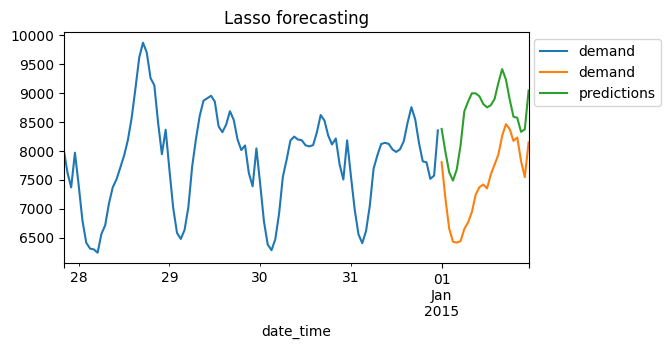

In [11]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(100).plot(ax=ax, label='train')
X_test.head(24).plot(ax=ax, label='train')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

Let's now calculate the error over those 24 hs. That is the difference between each forecast and the actual values.

In [12]:
# Prediction error

error_mse = mean_squared_error(
                y_true = X_test["demand"].head(24),
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1583738.8036404753


Say we want to predict energy demand later in the future with the model we just trained.

First, we need to gather the data necessary to create the lags. 

And then pass that past data to the forecaster.

## Predict any time point in the future

In [13]:
# the amount of data in the past that we need to create the features

forecaster.window_size

np.int64(24)

In [14]:
# Say we want to predict energy demand for 1st of February

forecast_start = '2015-02-01 00:00:00'

# we need the energy demand up to 144 hs before that point
past_data_available = X_test[:'2015-01-31 23:59:59'].tail(24)

past_data_available.head()

,demand
date_time,
2015-01-31 00:00:00,7844.738566
2015-01-31 01:00:00,7164.501132
2015-01-31 02:00:00,6689.463174
2015-01-31 03:00:00,6553.640100
2015-01-31 04:00:00,6691.974048


In [15]:
past_data_available.tail()

,demand
date_time,
2015-01-31 19:00:00,8441.928878
2015-01-31 20:00:00,8391.374590
2015-01-31 21:00:00,7949.156096
2015-01-31 22:00:00,7702.117400
2015-01-31 23:00:00,8345.948980


In [16]:
# Forecast next 24 hs starting Feb 2015

predictions = forecaster.predict(
    steps=24, 
    last_window=past_data_available["demand"], # we pass the data up to Feb 2015
)

predictions.head()

2015-02-01 00:00:00    8337.080217
2015-02-01 01:00:00    7865.817156
2015-02-01 02:00:00    7486.651096
2015-02-01 03:00:00    7369.927691
2015-02-01 04:00:00    7503.007594
Freq: h, Name: pred, dtype: float64

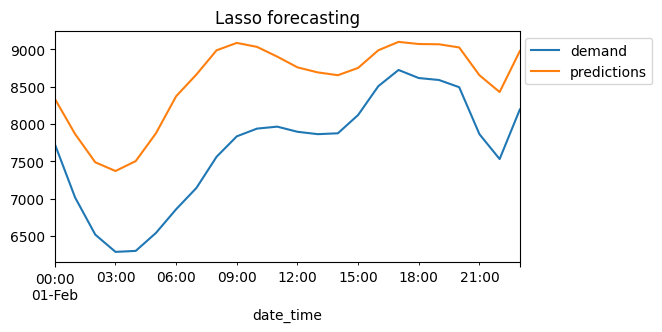

In [17]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_test['2015-01-31 23:59:59':].head(24).plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [18]:
# Prediction error

error_mse = mean_squared_error(
                y_true = X_test['2015-01-31 23:59:59':]["demand"].head(24),
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 926745.954176533


That's it! Now, we've trained a Lasso regression that we can use to forecast the next 24 hs based on historical data, at any point, provided we have the energy demand up to 144 hours before that point.

## Feature importance

We have various models, hence different importance for every step.

In [19]:
forecaster.regressors_

{1: Lasso(random_state=9),
 2: Lasso(random_state=9),
 3: Lasso(random_state=9),
 4: Lasso(random_state=9),
 5: Lasso(random_state=9),
 6: Lasso(random_state=9),
 7: Lasso(random_state=9),
 8: Lasso(random_state=9),
 9: Lasso(random_state=9),
 10: Lasso(random_state=9),
 11: Lasso(random_state=9),
 12: Lasso(random_state=9),
 13: Lasso(random_state=9),
 14: Lasso(random_state=9),
 15: Lasso(random_state=9),
 16: Lasso(random_state=9),
 17: Lasso(random_state=9),
 18: Lasso(random_state=9),
 19: Lasso(random_state=9),
 20: Lasso(random_state=9),
 21: Lasso(random_state=9),
 22: Lasso(random_state=9),
 23: Lasso(random_state=9),
 24: Lasso(random_state=9)}

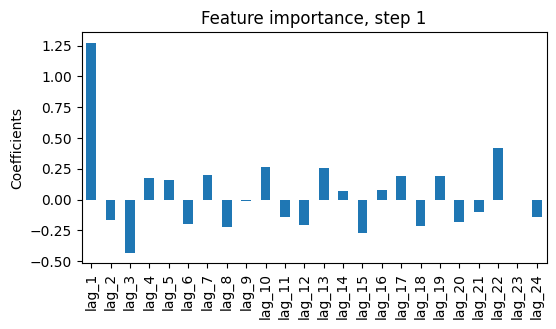

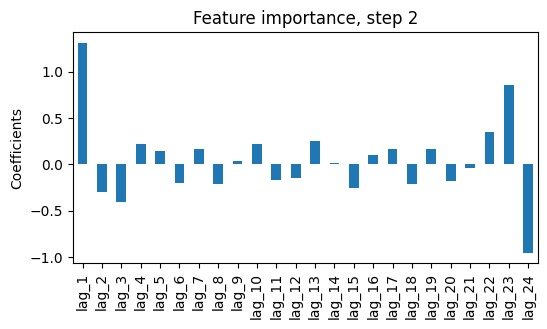

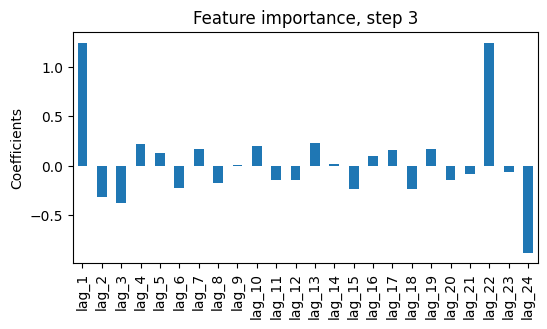

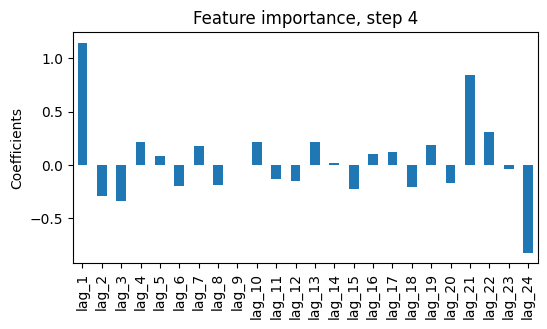

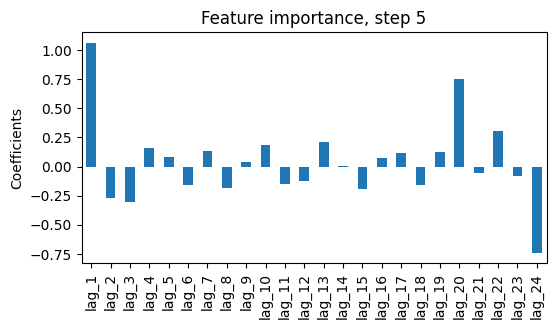

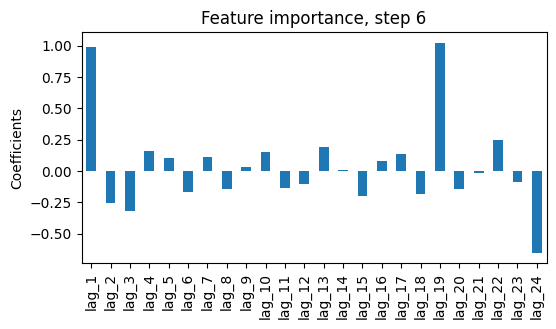

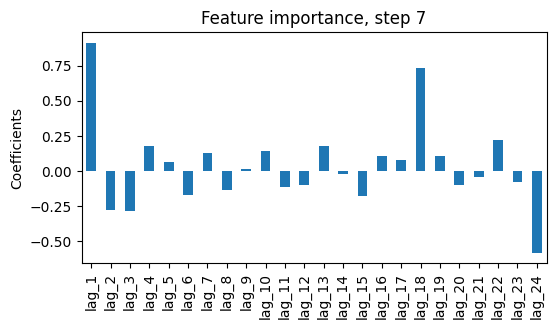

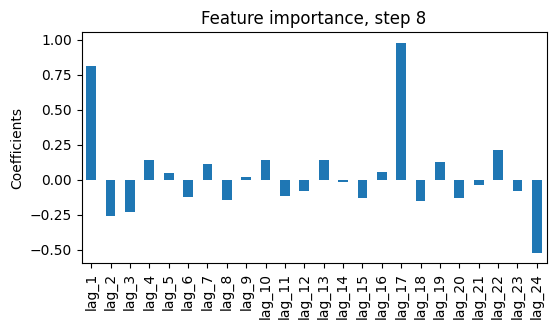

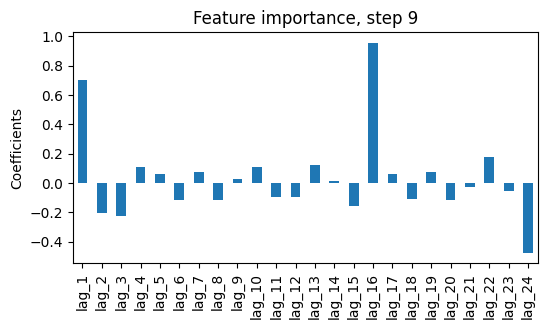

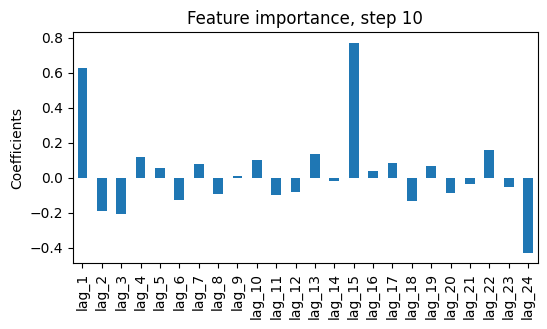

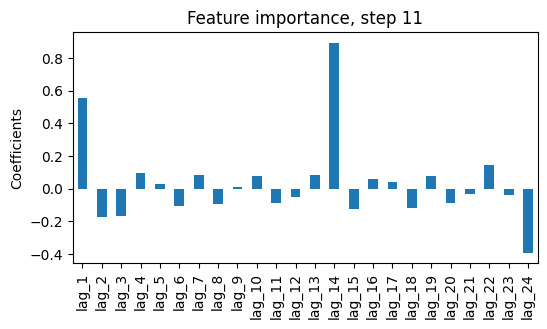

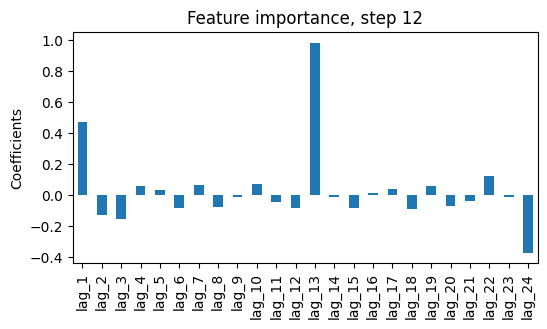

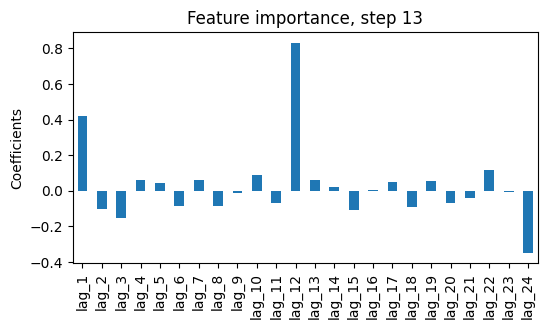

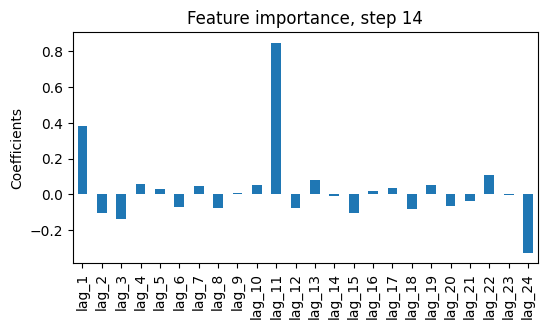

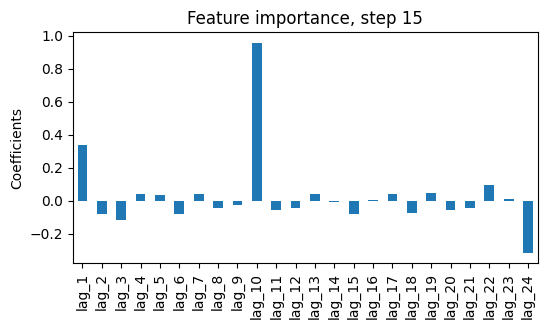

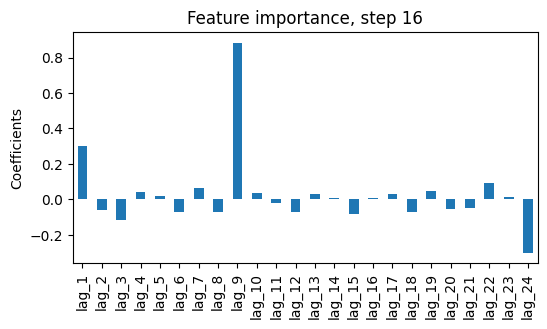

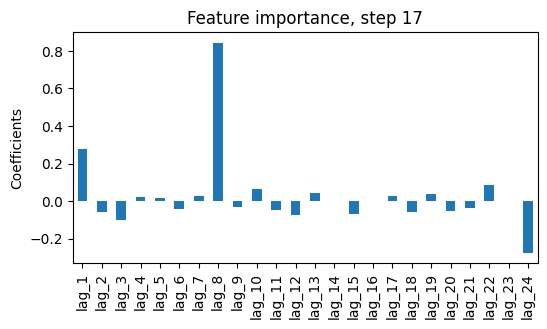

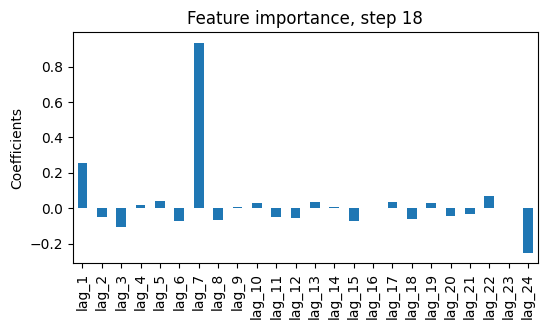

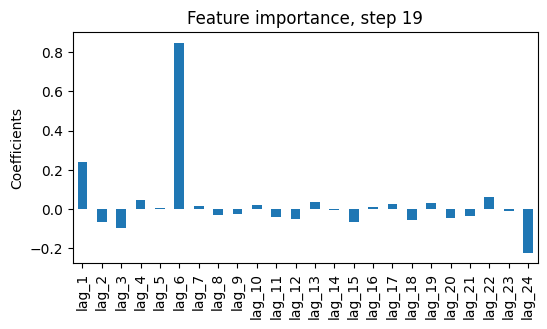

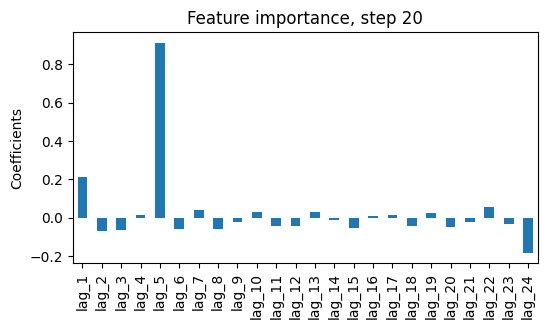

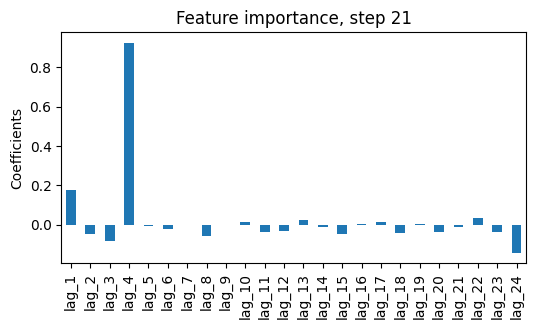

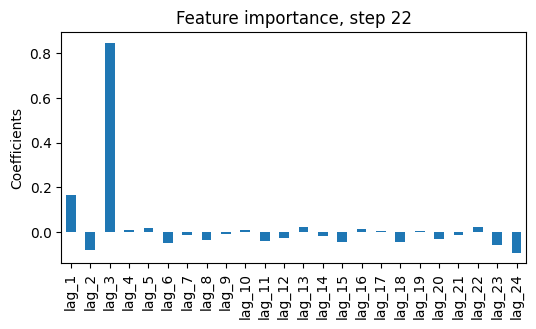

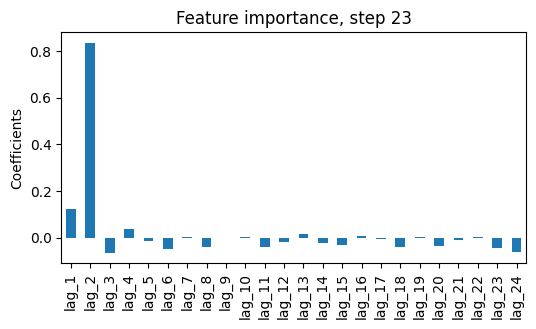

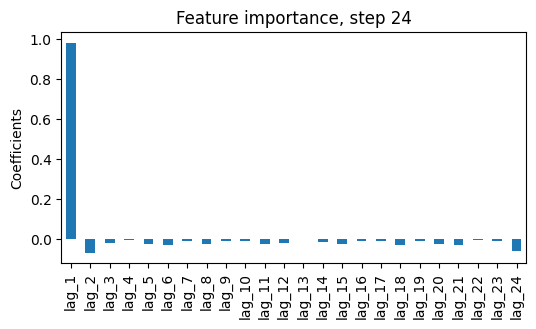

In [20]:
for h in range(1,25):
    lasso_ = forecaster.regressors_[h]
    pd.Series(lasso_.coef_,
          index=lasso_.feature_names_in_).plot.bar(figsize=(6,3))
    plt.title(f'Feature importance, step {h}')
    plt.ylabel('Coefficients')
    plt.show()    

That's it! Now we have a model, or better said, various models, that help us forecast 24 hs of energy demand based on previous consumption.